In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
from datetime import datetime, timedelta

,date,open,high,low,close,vol
16768,2015-01-02 17:30:00,57.343333,57.511667,56.853333,57.465783,343548
16769,2015-01-02 17:45:00,57.386667,57.991650,57.295000,57.991650,1057068
16770,2015-01-02 18:00:00,57.935000,58.186667,57.925017,58.143333,1037964
16771,2015-01-02 18:15:00,58.183333,58.286667,58.085167,58.221667,634836
16772,2015-01-02 18:30:00,58.211667,58.211667,57.550000,57.751667,597900


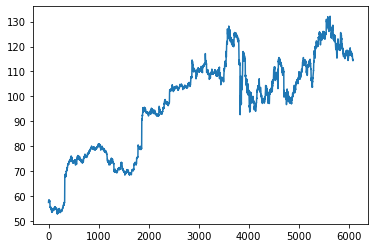

In [173]:
data = pd.read_parquet('resources/NFLX/NFLX-15min.parquet')
data = data[(data['date'] > datetime(2015, 1, 1)) & (data['date'] < datetime(2016, 1, 1))]

def plot_data(data):
    X = np.arange(0, len(data), 1)
    plt.plot(X, data['close'].values)

plot_data(data)
data.head()

In [174]:
def calc_up_candles(candles, coef_up):
    prices = candles[['open', 'close']].values
    up_candles = []
    i = 0
    n = prices.shape[0]
    up_count = 0
    while i < n:
        cur_open = prices[i][0]
        cur_close = prices[i][1]
        if up_count == 2:
            up_count = 0
            up_candles.append([cur_open, cur_close])
            while i < n and prices[i][0] <= prices[i][1]:
                i += 1
            i += 1
            continue
        if cur_close / cur_open >= coef_up:
            up_count += 1
        else:
            up_count = 0
        i += 1
    return np.array(up_candles)

def to_percents(candles):
    percents = []
    for candle in candles:
        percents.append((candle[1] / candle[0] - 1) * 100)
    return np.array(percents)

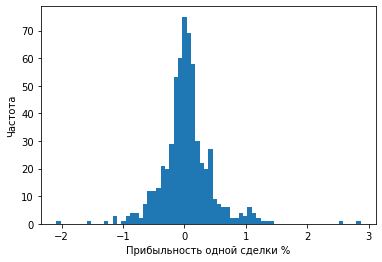

In [181]:
candles = calc_up_candles(data, coef_up=1.00044)
percents = to_percents(candles)

def plot_hist(data):
    plt.hist(data, bins=70)
    plt.xlabel('Прибыльность одной сделки %')
    plt.ylabel('Частота')

plot_hist(percents)

In [176]:
def plot_hist_and_distr(data, distr):
    plt.hist(data, bins=70, density=True)
    X = np.linspace(-3, 3, 200)
    plt.plot(X, distr.pdf(X), 'r-')
    plt.xlabel('Прибыльность одной сделки %')
    plt.ylabel('Плотность распределения')

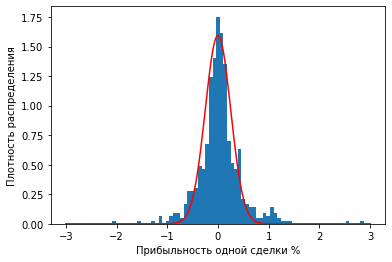

In [177]:
mean = np.mean(percents)
std_dev = np.std(percents)

norm = sps.norm(loc=0, scale=0.25)
plot_hist_and_distr(percents, norm)

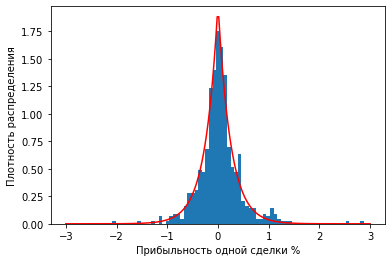

In [178]:
laplace = sps.laplace(loc=0, scale=0.25)
plot_hist_and_distr(percents, laplace)

In [179]:
n = len(percents)
x = [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 3]
theor_sample = laplace.rvs(n)
observed = np.zeros(len(x))
expected = np.zeros(len(x))
observed[0] = len(percents[percents < x[0]])
expected[0] = len(theor_sample[theor_sample < x[0]])
for i in range(1, len(x)):
    expected[i] = len(percents[(percents >= x[i - 1]) & (percents < x[i])])
    observed[i] = len(theor_sample[(theor_sample >= x[i - 1]) & (theor_sample < x[i])])

table = np.vstack((observed, expected))

In [180]:
def calc_pirson(freq):
    all_sum = np.sum(freq)
    vert_sums = np.sum(freq, axis=0)
    hor_sums = np.sum(freq, axis=1)
    res = 0
    for i in range(freq.shape[0]):
        for j in range(freq.shape[1]):
            res += (freq[i][j] ** 2) * 1.0 / (hor_sums[i] * vert_sums[j])
    return all_sum * (res - 1)

def out_pirson_results(freq, df):
    pirson = calc_pirson(freq)
    chi_sq = sps.chi2(df=df)
    prob = 1 - chi_sq.cdf(pirson)
    print("Значение статистики Пирсона: {:.2f}".format(pirson))
    print("Число степеней свободы: {:d}".format(df))
    print("Минимальный уровень значимости: {:.6f}".format(prob))

out_pirson_results(table, df=11)



Значение статистики Пирсона: 12.03
Число степеней свободы: 11
Минимальный уровень значимости: 0.361694
